## import needed packages

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler,OneHotEncoder,LabelEncoder,FunctionTransformer
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest,f_regression

## reading data

In [3]:
data=pd.read_csv('/kaggle/input/tehranhouses/tehranhouses.csv')


In [4]:
data.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1850000000,61666.67
1,60,1,True,True,True,Shahran,1850000000,61666.67
2,79,2,True,True,True,Pardis,550000000,18333.33
3,95,2,True,True,True,Shahrake Qods,902500000,30083.33
4,123,2,True,True,True,Shahrake Gharb,7000000000,233333.33


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   int64  
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(1), int64(2), object(2)
memory usage: 146.2+ KB


In [6]:
data.describe().style.format({'Price':'{:,.0f}'})

,Room,Price,Price(USD)
count,3479.000000,"3,479",3479.000000
mean,2.079908,"5,359,022,711",178634.090405
std,0.758275,"8,099,934,524",269997.817408
min,0.000000,"3,600,000",120.000000
25%,2.000000,"1,418,250,000",47275.000000
50%,2.000000,"2,900,000,000",96666.670000
75%,2.000000,"6,000,000,000",200000.000000
max,5.000000,"92,400,000,000",3080000.000000


In [7]:
data_copy=data.copy()

In [8]:
data=data.drop('Price(USD)',axis=1)

## EDA

In [9]:
data.Address.value_counts()

Address
Punak                     161
Pardis                    146
West Ferdows Boulevard    145
Gheitarieh                141
Shahran                   130
                         ... 
Firoozkooh                  1
Shadabad                    1
Naziabad                    1
Javadiyeh                   1
Yakhchiabad                 1
Name: count, Length: 192, dtype: int64

In [10]:
data.Room.value_counts()

Room
2    1961
3     732
1     673
4      70
5      33
0      10
Name: count, dtype: int64

In [11]:
pd.crosstab(data.Parking,data.Room)

Room,0,1,2,3,4,5
Parking,,,,,,
False,8,245,244,26,1,5
True,2,428,1717,706,69,28


In [12]:
pd.crosstab(data.Elevator,data.Room)

Room,0,1,2,3,4,5
Elevator,,,,,,
False,8,285,354,49,17,27
True,2,388,1607,683,53,6


In [13]:
pd.crosstab(
    index=[data['Room']],
    columns=[data['Parking'],data['Elevator'],data['Warehouse']]
)


Parking   False                   True                   
Elevator  False       True        False       True       
Warehouse False True  False True  False True  False True 
Room                                                     
0             5     3     0     0     0     0     0     2
1            51   122    27    45     6   106    26   290
2            60    72    34    78     5   217    52  1443
3             8     7     5     6     2    32     6   666
4             1     0     0     0     0    16     2    51
5             4     0     1     0     2    21     0     5

In [14]:
data.groupby(['Parking','Elevator','Warehouse'])[['Price']].mean().style.format({'Price':'{:,.0f}'})

In [15]:
data_eda=data.copy()
data_eda['Area']=data_eda['Area'].str.replace(r'\D+','',regex=True).astype(int)

In [16]:
data_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Area       3479 non-null   int64 
 1   Room       3479 non-null   int64 
 2   Parking    3479 non-null   bool  
 3   Warehouse  3479 non-null   bool  
 4   Elevator   3479 non-null   bool  
 5   Address    3456 non-null   object
 6   Price      3479 non-null   int64 
dtypes: bool(3), int64(3), object(1)
memory usage: 119.0+ KB


In [17]:
data_eda.groupby(['Parking','Elevator','Warehouse'])[['Area']].mean().style.format({'Area':'{:.0f}'})

In [18]:
must_delet_indexes=data_eda[data_eda.Area>1000].index.to_list()

In [19]:
def IQR(df,col):
    Q1=df[col].quantile(0.25)
    Q3=df[col].quantile(0.75)
    iqr=Q3-Q1
    lower=Q1-1.5*iqr
    upper=Q3+1.5*iqr
    outliers=df[(df[col]<lower)|(df[col]>upper)]
    clean_data=df[(df[col]>=lower)&(df[col]<=upper)]
    n_removed=len(outliers)
    return clean_data,outliers,n_removed

In [20]:
clean_data,outliers,n_removed=IQR(data_eda,'Area')
clean_data.info()
n_removed
outliers.describe().style.format({'Area':'{:,.0f}'})

<class 'pandas.core.frame.DataFrame'>
Index: 3235 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Area       3235 non-null   int64 
 1   Room       3235 non-null   int64 
 2   Parking    3235 non-null   bool  
 3   Warehouse  3235 non-null   bool  
 4   Elevator   3235 non-null   bool  
 5   Address    3212 non-null   object
 6   Price      3235 non-null   int64 
dtypes: bool(3), int64(3), object(1)
memory usage: 135.8+ KB


,Area,Room,Price
count,244,244.000000,244.000000
mean,"124,672,434",3.360656,24663926229.508198
std,"1,192,175,546",0.837059,18394578948.093998
min,197,0.000000,1000000000.000000
25%,210,3.000000,13275000000.000000
50%,240,3.000000,20000000000.000000
75%,314,4.000000,34000000000.000000
max,"16,160,000,000",5.000000,92400000000.000000


In [21]:
outliers.sort_values('Price',ascending=False).style.format({'Price':'{:,.0f}'})

,Area,Room,Parking,Warehouse,Elevator,Address,Price
1707,420,4,True,True,True,Zaferanieh,"92,400,000,000"
1810,705,5,True,True,False,Abazar,"91,000,000,000"
430,400,5,True,True,False,Lavasan,"85,000,000,000"
819,680,5,True,True,False,Ekhtiarieh,"81,600,000,000"
1332,350,4,True,True,True,Niavaran,"80,500,000,000"
1694,929,5,True,True,False,Zafar,"80,000,000,000"
3051,530,4,True,True,True,Dorous,"79,500,000,000"
3107,630,0,False,False,False,Tajrish,"75,600,000,000"
831,750,5,True,True,True,Mahmoudieh,"75,000,000,000"
2394,310,3,True,True,True,Aqdasieh,"74,400,000,000"


In [22]:
address=data.Address.value_counts()
data[data.Address.isin(address[address>10].index.to_list())].groupby('Address')[['Price']].mean().sort_values(by='Price',ascending=False).style.format('{:,.0f}')

,Price
Address,
Elahieh,"26,786,352,941"
Zaferanieh,"23,575,148,148"
Velenjak,"21,381,363,636"
Farmanieh,"20,917,280,702"
Niavaran,"19,893,205,882"
Dorous,"18,734,615,385"
Kamranieh,"18,301,428,571"
Aqdasieh,"17,580,000,000"
Shahrake Gharb,"11,969,881,356"


## visulization

<Axes: xlabel='Price', ylabel='Density'>

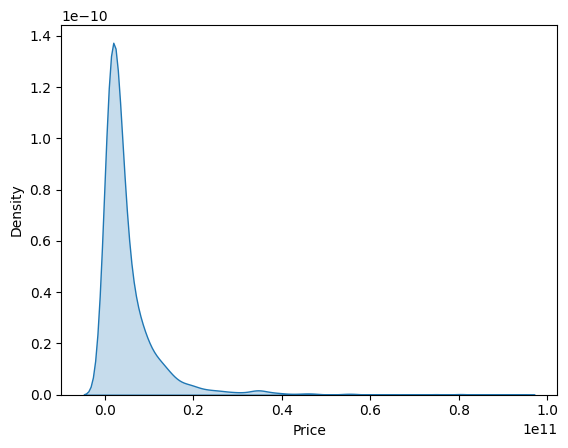

In [23]:
sns.kdeplot(data=data,x='Price',fill=True)

<Axes: xlabel='Price'>

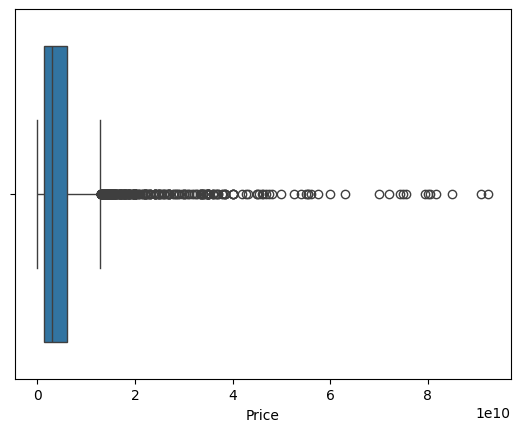

In [24]:
sns.boxplot(data=data,x='Price')

<Axes: xlabel='Price', ylabel='Count'>

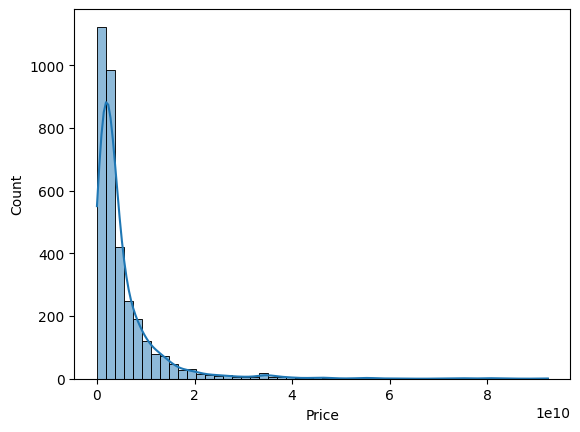

In [25]:
sns.histplot(data=data,x='Price',kde=True,bins=50)

<Axes: xlabel='Area', ylabel='Count'>

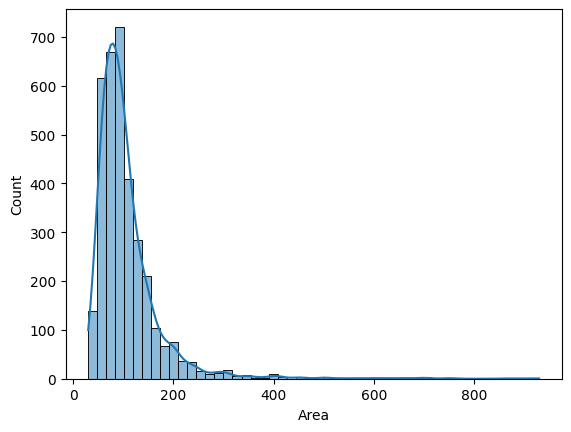

In [26]:
sns.histplot(data=data_eda[data_eda.Area<1000],x='Area',kde=True,bins=50)

<Axes: xlabel='Area', ylabel='Density'>

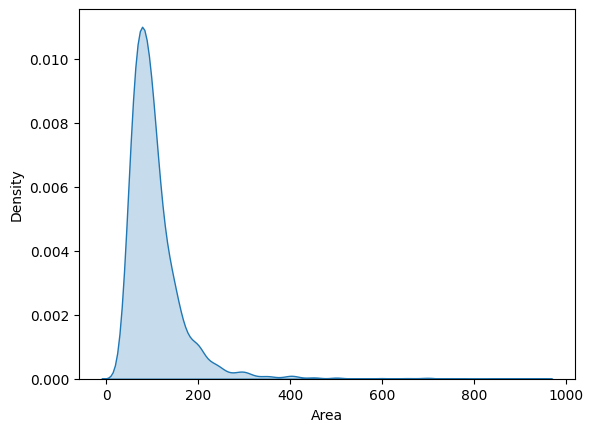

In [27]:
sns.kdeplot(data=data_eda[data_eda.Area<1000],x='Area',fill=True)

<Axes: xlabel='Area'>

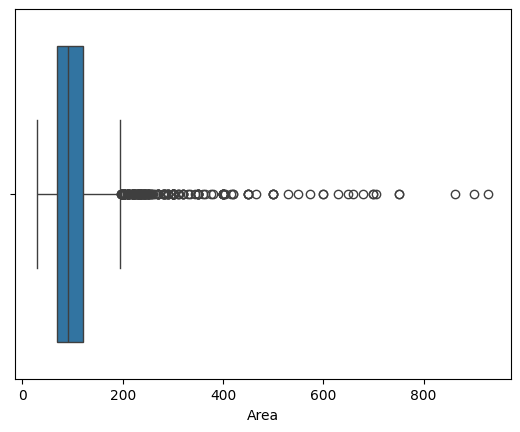

In [28]:
sns.boxplot(data=data_eda[data_eda.Area<1000],x='Area')

<Axes: xlabel='Room', ylabel='count'>

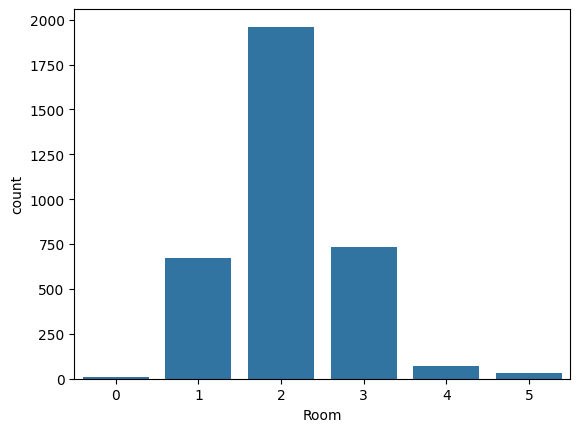

In [29]:
sns.countplot(data=data,x='Room')

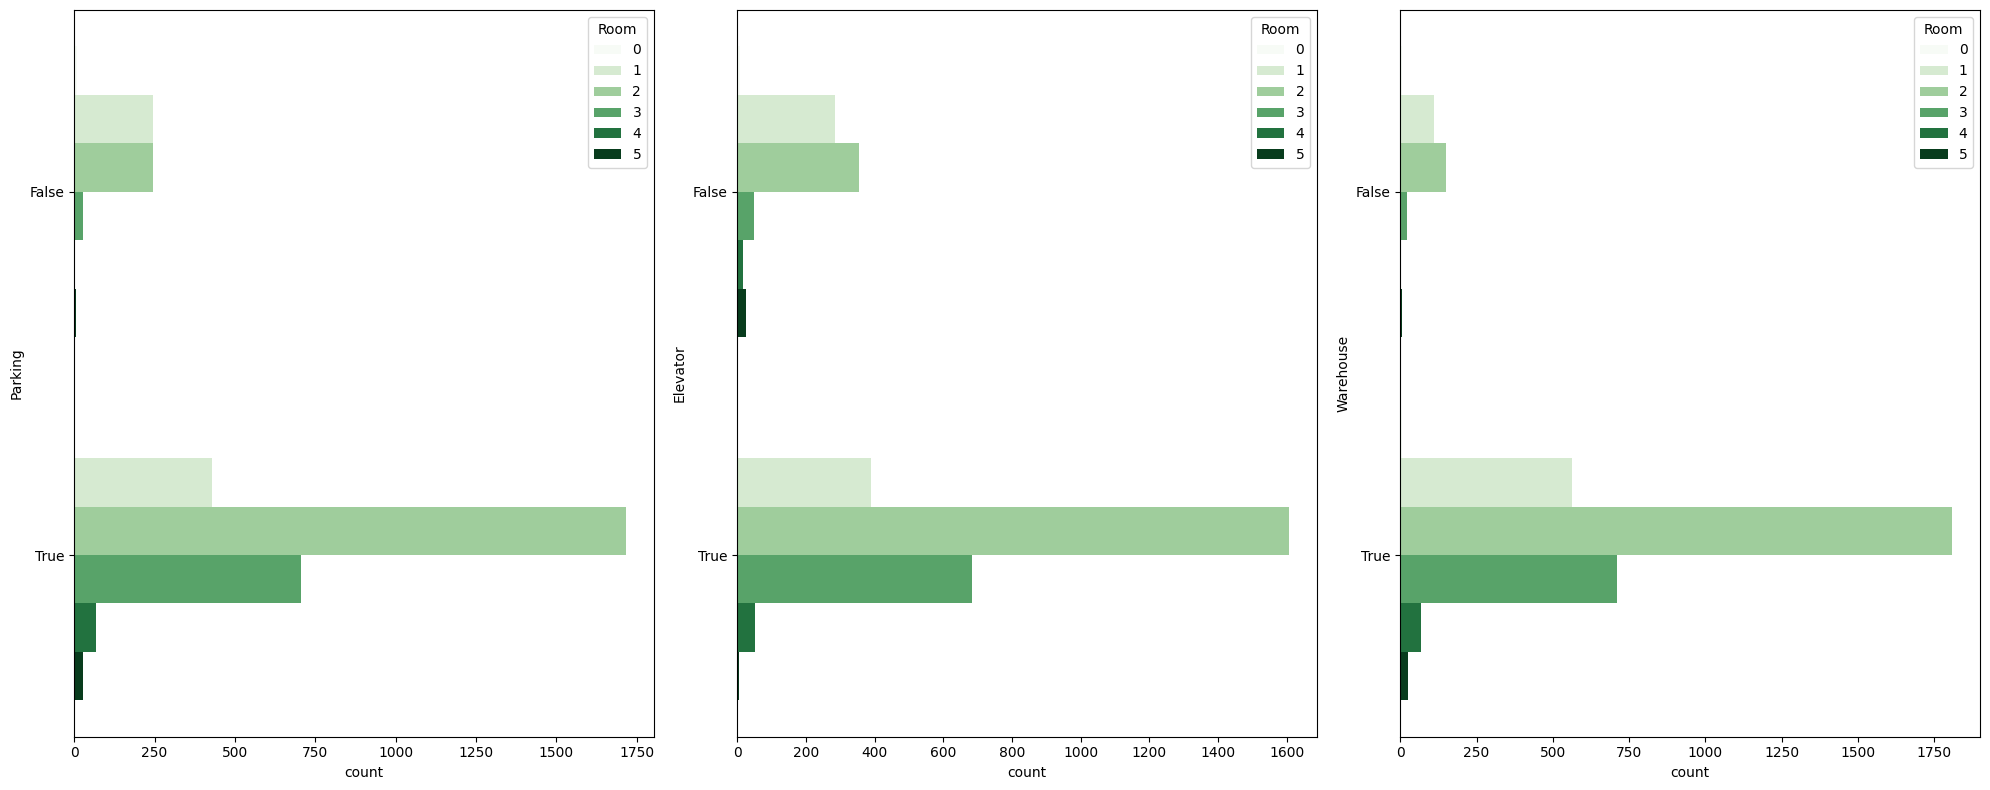

In [30]:
fig,ax=plt.subplots(1,3,figsize=(20,8))
sns.countplot(data=data,y='Parking',hue='Room',ax=ax[0],palette='Greens')
sns.countplot(data=data,y='Elevator',hue='Room',ax=ax[1],palette='Greens')
sns.countplot(data=data,y='Warehouse',hue='Room',ax=ax[2],palette='Greens')
plt.tight_layout()
plt.show()

<Axes: >

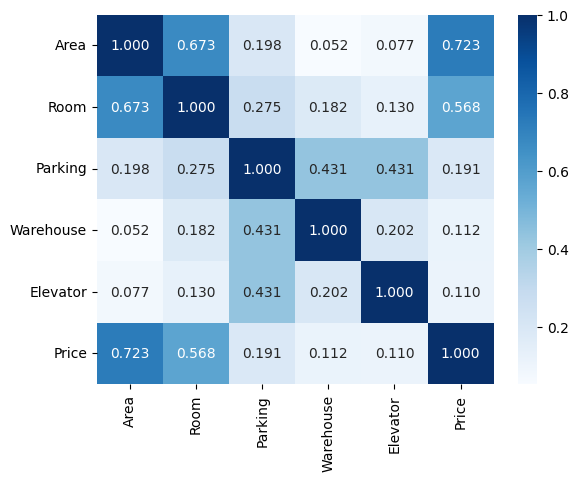

In [31]:
data_eda[['Parking','Warehouse','Elevator']]=data_eda[['Parking','Elevator','Warehouse']].astype('int')
sns.heatmap(data_eda[data_eda.Area<1000].select_dtypes(include='number').corr(),annot=True,cmap='Blues',fmt='.3f',annot_kws={'size':10})

## Cleaning and Preprocessing

In [32]:
data

,Area,Room,Parking,Warehouse,Elevator,Address,Price
0,63,1,True,True,True,Shahran,1850000000
1,60,1,True,True,True,Shahran,1850000000
2,79,2,True,True,True,Pardis,550000000
3,95,2,True,True,True,Shahrake Qods,902500000
4,123,2,True,True,True,Shahrake Gharb,7000000000
...,...,...,...,...,...,...,...
3474,86,2,True,True,True,Southern Janatabad,3500000000
3475,83,2,True,True,True,Niavaran,6800000000
3476,75,2,False,False,False,Parand,365000000
3477,105,2,True,True,True,Dorous,5600000000


In [33]:
data=data.drop(index=must_delet_indexes)

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3474 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Area       3474 non-null   object
 1   Room       3474 non-null   int64 
 2   Parking    3474 non-null   bool  
 3   Warehouse  3474 non-null   bool  
 4   Elevator   3474 non-null   bool  
 5   Address    3451 non-null   object
 6   Price      3474 non-null   int64 
dtypes: bool(3), int64(2), object(2)
memory usage: 145.9+ KB


In [35]:
data[['Parking','Warehouse','Elevator']]=data[['Parking','Warehouse','Elevator']].astype('int')

In [36]:
addresses=data.Address.value_counts()
small_addresses=addresses[address<5].index.to_list()
large_addresses=addresses[address>=5].index.to_list()

In [37]:
def Area_to_number(X):
  X=X.copy()
  X['Area']=X['Area'].str.replace('\D+','',regex=True).astype(int)
  return X

In [38]:
def clip_Area(X):
  X=X.copy()
  X['Area']=X['Area'].clip(20,1000)
  return X

In [39]:
def map_Address(X):
  X=X.copy()
  for i in X.Address:
    if i in small_addresses or i=='Other':
      X.loc[X.Address==i,'Address']='Other'
    elif i in large_addresses:
      X.loc[X.Address==i,'Address']=i
    else:
      X.loc[X.Address==i,'Address']='Other'
  return X


In [40]:
Area_pipe=Pipeline([('to_numeric',FunctionTransformer(Area_to_number)),('clip',FunctionTransformer(clip_Area)),('imputer',SimpleImputer(strategy='mean')),('scaler',StandardScaler())])

In [41]:
Room_pipe=Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),('scaler',StandardScaler())])

In [42]:
bool_cols=['Parking','Warehouse','Elevator']
bool_pipe=Pipeline([('imputer',SimpleImputer(strategy='most_frequent'))])

In [43]:
Address_pipe=Pipeline([('map',FunctionTransformer(map_Address)),('encoder',OneHotEncoder(handle_unknown='ignore',drop='first'))])

In [44]:
preprocessor=ColumnTransformer([('Area',Area_pipe,['Area']),('Room',Room_pipe,['Room']),('bool',bool_pipe,bool_cols),('Address',Address_pipe,['Address'])])

## Modeling

In [45]:
data=data.dropna()

In [46]:
data

,Area,Room,Parking,Warehouse,Elevator,Address,Price
0,63,1,1,1,1,Shahran,1850000000
1,60,1,1,1,1,Shahran,1850000000
2,79,2,1,1,1,Pardis,550000000
3,95,2,1,1,1,Shahrake Qods,902500000
4,123,2,1,1,1,Shahrake Gharb,7000000000
...,...,...,...,...,...,...,...
3474,86,2,1,1,1,Southern Janatabad,3500000000
3475,83,2,1,1,1,Niavaran,6800000000
3476,75,2,0,0,0,Parand,365000000
3477,105,2,1,1,1,Dorous,5600000000


In [47]:
X=data.drop('Price',axis=1)
y=data['Price']

In [48]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [49]:
X_train.shape

(2760, 6)

In [50]:
X_test.shape

(691, 6)

In [51]:
models=[LinearRegression(),Lasso(),Ridge(),ElasticNet(),DecisionTreeRegressor(),RandomForestRegressor(),KNeighborsRegressor(),SVR(),XGBRegressor()]

### Model1=LinearRegression()

In [52]:
model1=LinearRegression()

In [53]:
pipe1=Pipeline([('preprocessor',preprocessor),('model',model1)])


In [54]:
pipe1.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Area',
                                                  Pipeline(steps=[('to_numeric',
                                                                   FunctionTransformer(func=<function Area_to_number at 0x78a02457c180>)),
                                                                  ('clip',
                                                                   FunctionTransformer(func=<function clip_Area at 0x78a02457c720>)),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Area']),
                                                 ('Room',
                                                  Pipeline(steps=[('imputer',
                                                                   Simple...
                                                                   StandardScaler())]),
                                                  ['Room']),
                                                 ('bool',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Parking', 'Warehouse',
                                                   'Elevator']),
                                                 ('Address',
                                                  Pipeline(steps=[('map',
                                                                   FunctionTransformer(func=<function map_Address at 0x78a02457ca40>)),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Address'])])),
                ('model', LinearRegression())])

In [55]:
scores1=cross_val_score(pipe1,X_train,y_train,cv=5,scoring='r2')
print('scores',scores1)
print('mean',scores1.mean())
print('std',scores1.std())

scores [0.31686591 0.62229437 0.63010098 0.72467758 0.75409099]
mean 0.6096059651193659
std 0.15517421398320927


In [56]:
pipe1.score(X_test,y_test)


0.7319633912442688

In [57]:
Grid1=GridSearchCV(pipe1,param_grid={'model__fit_intercept':[True,False]},cv=5,scoring='r2')
Grid1.fit(X_train,y_train)
print('best_params',Grid1.best_params_)
print('best_score',Grid1.best_score_)


best_params {'model__fit_intercept': True}
best_score 0.6096059651193659


In [58]:
y_pred=Grid1.predict(X_test)
print('final_score',Grid1.best_estimator_.score(X_test,y_test))
print('MAE',mean_absolute_error(y_test,y_pred))

final_score 0.7319633912442688
MAE 1924740959.727227


In [156]:
scoreses={}
scoreses['LinearRegression()']=Grid1.best_estimator_.score(X_test,y_test)

In [157]:
pipes={}
pipes['LinearRegression()']=Grid1.best_estimator_

In [153]:
pipes

{'LinearRegression': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('Area',
                                                   Pipeline(steps=[('to_numeric',
                                                                    FunctionTransformer(func=<function Area_to_number at 0x78a02457c180>)),
                                                                   ('clip',
                                                                    FunctionTransformer(func=<function clip_Area at 0x78a02457c720>)),
                                                                   ('imputer',
                                                                    SimpleImputer()),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['Area']),
                                                  ('Room',
 

In [60]:
scoreses

{'LinearRegression': 0.7319633912442688}

### Model2=Lasso()

In [61]:
model2=Lasso()

In [62]:
pipe2=Pipeline([('preprocessor',preprocessor),('model',model2)])

In [63]:
pipe2.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Area',
                                                  Pipeline(steps=[('to_numeric',
                                                                   FunctionTransformer(func=<function Area_to_number at 0x78a02457c180>)),
                                                                  ('clip',
                                                                   FunctionTransformer(func=<function clip_Area at 0x78a02457c720>)),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Area']),
                                                 ('Room',
                                                  Pipeline(steps=[('imputer',
                                                                   Simple...
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Room']),
                                                 ('bool',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Parking', 'Warehouse',
                                                   'Elevator']),
                                                 ('Address',
                                                  Pipeline(steps=[('map',
                                                                   FunctionTransformer(func=<function map_Address at 0x78a02457ca40>)),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Address'])])),
                ('model', Lasso())])

In [64]:
scores2=cross_val_score(pipe2,X_train,y_train,cv=5,scoring='r2')
print('scores',scores2)
print('mean',scores2.mean())
print('std',scores2.std())

scores [0.31686886 0.62229481 0.63009934 0.7246789  0.75409128]
mean 0.6096066364103854
std 0.1551733131217881


In [65]:
pipe2.score(X_test,y_test)

0.731962366914376

In [66]:
Grid2=GridSearchCV(pipe2,param_grid={'model__alpha':np.linspace(0.01,1,10)},cv=5,scoring='r2')
Grid2.fit(X_train,y_train)
print('best_params',Grid2.best_params_)
print('best_score',Grid2.best_score_)

best_params {'model__alpha': np.float64(1.0)}
best_score 0.6096066364103854


In [67]:
y_pred2=Grid2.predict(X_test)
print('final_score',Grid2.best_estimator_.score(X_test,y_test))
print('MAE',mean_absolute_error(y_test,y_pred2))

final_score 0.731962366914376
MAE 1924757122.6684797


In [68]:
scoreses['Lasso()']=Grid2.best_estimator_.score(X_test,y_test)

In [69]:
scoreses

{'LinearRegression': 0.7319633912442688, 'Lasso()': 0.731962366914376}

In [154]:
pipes['Lasso()']=Grid2.best_estimator_

### Model3=Ridge()

In [70]:
model3=Ridge()

In [71]:
pipe3=Pipeline([('preprocessor',preprocessor),('model',model3)])

In [72]:
pipe3.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Area',
                                                  Pipeline(steps=[('to_numeric',
                                                                   FunctionTransformer(func=<function Area_to_number at 0x78a02457c180>)),
                                                                  ('clip',
                                                                   FunctionTransformer(func=<function clip_Area at 0x78a02457c720>)),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Area']),
                                                 ('Room',
                                                  Pipeline(steps=[('imputer',
                                                                   Simple...
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Room']),
                                                 ('bool',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Parking', 'Warehouse',
                                                   'Elevator']),
                                                 ('Address',
                                                  Pipeline(steps=[('map',
                                                                   FunctionTransformer(func=<function map_Address at 0x78a02457ca40>)),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Address'])])),
                ('model', Ridge())])

In [73]:
scores3=cross_val_score(pipe3,X_train,y_train,cv=5,scoring='r2')
print('scores',scores3)
print('mean',scores3.mean())
print('std',scores3.std())

scores [0.38920292 0.62107321 0.63815079 0.71533171 0.75281233]
mean 0.6233141943743542
std 0.126704559052719


In [74]:
pipe3.score(X_test,y_test)

0.7302862107963201

In [75]:
param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10, 100],  # فقط 5 مقدار
    'model__fit_intercept': [True],           # معمولاً True کافی
    'model__solver': ['auto', 'lsqr']         # دو تا solver سریع
}
Grid3=GridSearchCV(pipe3,param_grid=param_grid,cv=5,scoring='r2')
Grid3.fit(X_train,y_train)
print('best_params',Grid3.best_params_)
print('best_score',Grid3.best_score_)

best_params {'model__alpha': 1, 'model__fit_intercept': True, 'model__solver': 'lsqr'}
best_score 0.6233237429106329


In [76]:
y_pred3=Grid3.predict(X_test)
print('final_score',Grid3.best_estimator_.score(X_test,y_test))
print('MAE',mean_absolute_error(y_test,y_pred3))

final_score 0.7304129373494621
MAE 1909294802.5665998


In [77]:
scoreses['Ridge()']=Grid3.best_estimator_.score(X_test,y_test)

In [78]:
scoreses

{'LinearRegression': 0.7319633912442688,
 'Lasso()': 0.731962366914376,
 'Ridge()': 0.7304129373494621}

In [155]:
pipes['Ridge()']=Grid3.best_estimator_

### Model4=Elasticnet()

In [79]:
model4=ElasticNet()

In [80]:
pipe4=Pipeline([('preprocessor',preprocessor),('model',model4)])

In [81]:
pipe4.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Area',
                                                  Pipeline(steps=[('to_numeric',
                                                                   FunctionTransformer(func=<function Area_to_number at 0x78a02457c180>)),
                                                                  ('clip',
                                                                   FunctionTransformer(func=<function clip_Area at 0x78a02457c720>)),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Area']),
                                                 ('Room',
                                                  Pipeline(steps=[('imputer',
                                                                   Simple...
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Room']),
                                                 ('bool',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Parking', 'Warehouse',
                                                   'Elevator']),
                                                 ('Address',
                                                  Pipeline(steps=[('map',
                                                                   FunctionTransformer(func=<function map_Address at 0x78a02457ca40>)),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Address'])])),
                ('model', ElasticNet())])

In [82]:
scores4=cross_val_score(pipe4,X_train,y_train,cv=5,scoring='r2')
print('scores',scores4)
print('mean',scores4.mean())
print('std',scores4.std())

scores [0.36711871 0.47323818 0.49601817 0.49123889 0.52235679]
mean 0.46999414830886116
std 0.05378534224004333


In [83]:
pipe4.score(X_test,y_test)

0.5001777500730481

In [84]:
param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10, 100],      # ضریب Regularization
    'model__l1_ratio': [0.1, 0.5, 0.9],           # نسبت L1 و L2
    'model__fit_intercept': [True],               # معمولاً True کافی
    'model__max_iter': [1000]                     # حداقل iterations برای convergence
}

Grid4=GridSearchCV(pipe4,param_grid=param_grid,cv=5,scoring='r2')
Grid4.fit(X_train,y_train)
print('best_params',Grid4.best_params_)
print('best_score',Grid4.best_score_)

best_params {'model__alpha': 0.01, 'model__fit_intercept': True, 'model__l1_ratio': 0.9, 'model__max_iter': 1000}
best_score 0.62493286942467


In [85]:
y_pred4=Grid4.predict(X_test)
print('final_score',Grid4.best_estimator_.score(X_test,y_test))
print('MAE',mean_absolute_error(y_test,y_pred4))

final_score 0.7243252136446965
MAE 1919419720.3789196


In [86]:
scoreses['ElasticNet()']=Grid4.best_estimator_.score(X_test,y_test)

In [87]:
scoreses

{'LinearRegression': 0.7319633912442688,
 'Lasso()': 0.731962366914376,
 'Ridge()': 0.7304129373494621,
 'ElasticNet': 0.7243252136446965}

In [158]:
pipes['ElasticNet()']=Grid4.best_estimator_

### Model5=DecisionTreeRegressor()

In [88]:
model5=DecisionTreeRegressor()

In [89]:
pipe5=Pipeline([('preprocessor',preprocessor),('model',model5)])

In [90]:
pipe5.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Area',
                                                  Pipeline(steps=[('to_numeric',
                                                                   FunctionTransformer(func=<function Area_to_number at 0x78a02457c180>)),
                                                                  ('clip',
                                                                   FunctionTransformer(func=<function clip_Area at 0x78a02457c720>)),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Area']),
                                                 ('Room',
                                                  Pipeline(steps=[('imputer',
                                                                   Simple...
                                                                   StandardScaler())]),
                                                  ['Room']),
                                                 ('bool',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Parking', 'Warehouse',
                                                   'Elevator']),
                                                 ('Address',
                                                  Pipeline(steps=[('map',
                                                                   FunctionTransformer(func=<function map_Address at 0x78a02457ca40>)),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Address'])])),
                ('model', DecisionTreeRegressor())])

In [91]:
scores5=cross_val_score(pipe5,X_train,y_train,cv=5,scoring='r2')
print('scores',scores5)
print('mean',scores5.mean())
print('std',scores5.std())

scores [-0.12384399  0.25082291  0.49430397  0.62634522  0.42658606]
mean 0.3348428357768547
std 0.259334249435879


In [92]:
pipe5.score(X_test,y_test)

0.6518120843462178

In [93]:
param_grid = {
    'model__max_depth': [5, 10, None],         # فقط 3 گزینه
    'model__min_samples_split': [2, 5],        # 2 گزینه
    'model__min_samples_leaf': [1, 2],         # 2 گزینه
    'model__max_features': [None, 'sqrt']      # 2 گزینه
}


Grid5=GridSearchCV(pipe5,param_grid=param_grid,cv=5,scoring='r2')
Grid5.fit(X_train,y_train)
print('best_params',Grid5.best_params_)
print('best_score',Grid5.best_score_)

best_params {'model__max_depth': 10, 'model__max_features': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5}
best_score 0.6226510664126507


In [94]:
y_pred5=Grid5.predict(X_test)
print('final_score',Grid5.best_estimator_.score(X_test,y_test))
print('MAE',mean_absolute_error(y_test,y_pred5))

final_score 0.6136872842195951
MAE 1938215754.8535645


In [95]:
scoreses['DecisionTreeRegressor()']=Grid5.best_estimator_.score(X_test,y_test)

In [96]:
scoreses

{'LinearRegression': 0.7319633912442688,
 'Lasso()': 0.731962366914376,
 'Ridge()': 0.7304129373494621,
 'ElasticNet': 0.7243252136446965,
 'DecisionTreeRegressor()': 0.6136872842195951}

In [159]:
pipes['DecisionTreeRegressor()']=Grid5.best_estimator_

### Model6=RandomForestRegressor()

In [97]:
model6=RandomForestRegressor()

In [98]:
pipe6=Pipeline([('preprocessor',preprocessor),('model',model6)])

In [99]:
pipe6.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Area',
                                                  Pipeline(steps=[('to_numeric',
                                                                   FunctionTransformer(func=<function Area_to_number at 0x78a02457c180>)),
                                                                  ('clip',
                                                                   FunctionTransformer(func=<function clip_Area at 0x78a02457c720>)),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Area']),
                                                 ('Room',
                                                  Pipeline(steps=[('imputer',
                                                                   Simple...
                                                                   StandardScaler())]),
                                                  ['Room']),
                                                 ('bool',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Parking', 'Warehouse',
                                                   'Elevator']),
                                                 ('Address',
                                                  Pipeline(steps=[('map',
                                                                   FunctionTransformer(func=<function map_Address at 0x78a02457ca40>)),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Address'])])),
                ('model', RandomForestRegressor())])

In [100]:
scores6=cross_val_score(pipe6,X_train,y_train,cv=5,scoring='r2')
print('scores',scores6)
print('mean',scores6.mean())
print('std',scores6.std())

scores [0.55574471 0.58996497 0.66132245 0.76904004 0.74207708]
mean 0.6636298525564738
std 0.08286895300353736


In [101]:
pipe6.score(X_test,y_test)

0.8353345960415999

In [102]:
param_grid = {
    'model__n_estimators': [50, 100, 200],        # تعداد درخت‌ها
    'model__max_depth': [None, 10, 20],           # عمق درخت‌ها
    'model__min_samples_split': [2, 5],           # حداقل نمونه برای تقسیم داخلی
    'model__min_samples_leaf': [1, 2],            # حداقل نمونه در برگ
    'model__max_features': ['sqrt', 'log2']       # تعداد ویژگی‌ها برای هر تقسیم
}

Grid6=GridSearchCV(pipe6,param_grid=param_grid,cv=5,scoring='r2')
Grid6.fit(X_train,y_train)
print('best_params',Grid6.best_params_)
print('best_score',Grid6.best_score_)

best_params {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
best_score 0.7453024974556351


In [103]:
y_pred6=Grid6.predict(X_test)
print('final_score',Grid6.best_estimator_.score(X_test,y_test))
print('MAE',mean_absolute_error(y_test,y_pred6))

final_score 0.8385036165666057
MAE 1256094349.9586089


In [104]:
scoreses['RandomForestRegressor()']=Grid6.best_estimator_.score(X_test,y_test)

In [105]:
scoreses

{'LinearRegression': 0.7319633912442688,
 'Lasso()': 0.731962366914376,
 'Ridge()': 0.7304129373494621,
 'ElasticNet': 0.7243252136446965,
 'DecisionTreeRegressor()': 0.6136872842195951,
 'RandomForestRegressor()': 0.8385036165666057}

In [161]:
pipes['RandomForestRegressor()']=Grid6.best_estimator_

### Model7=KNeighborsRegressor()

In [106]:
model7=KNeighborsRegressor()

In [107]:
pipe7=Pipeline([('preprocessor',preprocessor),('model',model7)])

In [108]:
pipe7.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Area',
                                                  Pipeline(steps=[('to_numeric',
                                                                   FunctionTransformer(func=<function Area_to_number at 0x78a02457c180>)),
                                                                  ('clip',
                                                                   FunctionTransformer(func=<function clip_Area at 0x78a02457c720>)),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Area']),
                                                 ('Room',
                                                  Pipeline(steps=[('imputer',
                                                                   Simple...
                                                                   StandardScaler())]),
                                                  ['Room']),
                                                 ('bool',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Parking', 'Warehouse',
                                                   'Elevator']),
                                                 ('Address',
                                                  Pipeline(steps=[('map',
                                                                   FunctionTransformer(func=<function map_Address at 0x78a02457ca40>)),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Address'])])),
                ('model', KNeighborsRegressor())])

In [109]:
scores7=cross_val_score(pipe7,X_train,y_train,cv=5,scoring='r2')
print('scores',scores7)
print('mean',scores7.mean())
print('std',scores7.std())

scores [0.5291961  0.60552235 0.69966162 0.73023727 0.80017354]
mean 0.672958176841221
std 0.09528152362692034


In [110]:
pipe7.score(X_test,y_test)

0.8367843397763649

In [111]:
param_grid = {
    'model__n_neighbors': [3, 5, 7, 9, 11],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2]
}

Grid7=GridSearchCV(pipe7,param_grid=param_grid,cv=5,scoring='r2')
Grid7.fit(X_train,y_train)
print('best_params',Grid7.best_params_)
print('best_score',Grid7.best_score_)

best_params {'model__n_neighbors': 11, 'model__p': 1, 'model__weights': 'distance'}
best_score 0.7302433908981062


In [112]:
y_pred7=Grid7.predict(X_test)
print('final_score',Grid7.best_estimator_.score(X_test,y_test))
print('MAE',mean_absolute_error(y_test,y_pred7))

final_score 0.8284392691829142
MAE 1235899674.5976703


In [113]:
scoreses['KNeighborsRegressor()']=Grid7.best_estimator_.score(X_test,y_test)

In [114]:
scoreses

{'LinearRegression': 0.7319633912442688,
 'Lasso()': 0.731962366914376,
 'Ridge()': 0.7304129373494621,
 'ElasticNet': 0.7243252136446965,
 'DecisionTreeRegressor()': 0.6136872842195951,
 'RandomForestRegressor()': 0.8385036165666057,
 'KNeighborsRegressor()': 0.8284392691829142}

In [162]:
pipes['KNeighborsRegressor()']=Grid7.best_estimator_

### Model8=SVR()

In [115]:
model8=SVR()

In [116]:
pipe8=Pipeline([('preprocessor',preprocessor),('model',model8)])

In [117]:
pipe8.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Area',
                                                  Pipeline(steps=[('to_numeric',
                                                                   FunctionTransformer(func=<function Area_to_number at 0x78a02457c180>)),
                                                                  ('clip',
                                                                   FunctionTransformer(func=<function clip_Area at 0x78a02457c720>)),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Area']),
                                                 ('Room',
                                                  Pipeline(steps=[('imputer',
                                                                   Simple...
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Room']),
                                                 ('bool',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Parking', 'Warehouse',
                                                   'Elevator']),
                                                 ('Address',
                                                  Pipeline(steps=[('map',
                                                                   FunctionTransformer(func=<function map_Address at 0x78a02457ca40>)),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Address'])])),
                ('model', SVR())])

In [118]:
scores8=cross_val_score(pipe8,X_train,y_train,cv=5,scoring='r2')
print('scores',scores8)
print('mean',scores8.mean())
print('std',scores8.std())

scores [-0.11269128 -0.07457987 -0.10303572 -0.10416852 -0.08617482]
mean -0.0961300430796487
std 0.013784747630511057


In [119]:
pipe8.score(X_test,y_test)

-0.0850619097601768

In [120]:
param_grid = {
    'model__kernel': ['rbf'],
    'model__C': [1, 10, 100],
    'model__gamma': ['scale', 0.01, 0.1],
    'model__epsilon': [0.1, 0.2, 0.5]
}

Grid8=GridSearchCV(pipe8,param_grid=param_grid,cv=5,scoring='r2')
Grid8.fit(X_train,y_train)
print('best_params',Grid8.best_params_)
print('best_score',Grid8.best_score_)

best_params {'model__C': 100, 'model__epsilon': 0.1, 'model__gamma': 0.1, 'model__kernel': 'rbf'}
best_score -0.09612781800393524


In [121]:
y_pred8=Grid8.predict(X_test)
print('final_score',Grid8.best_estimator_.score(X_test,y_test))
print('MAE',mean_absolute_error(y_test,y_pred8))

final_score -0.08505934608884469
MAE 3795028047.4533386


In [122]:
scoreses['SVR()']=Grid8.best_estimator_.score(X_test,y_test)

In [123]:
scoreses

{'LinearRegression': 0.7319633912442688,
 'Lasso()': 0.731962366914376,
 'Ridge()': 0.7304129373494621,
 'ElasticNet': 0.7243252136446965,
 'DecisionTreeRegressor()': 0.6136872842195951,
 'RandomForestRegressor()': 0.8385036165666057,
 'KNeighborsRegressor()': 0.8284392691829142,
 'SVR()': -0.08505934608884469}

In [163]:
pipes['SVR()']=Grid8.best_estimator_

### MODEL9=XGBRegressor()

In [124]:
model9=XGBRegressor()

In [125]:
pipe9=Pipeline([('preprocessor',preprocessor),('model',model9)])

In [126]:
pipe9.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Area',
                                                  Pipeline(steps=[('to_numeric',
                                                                   FunctionTransformer(func=<function Area_to_number at 0x78a02457c180>)),
                                                                  ('clip',
                                                                   FunctionTransformer(func=<function clip_Area at 0x78a02457c720>)),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Area']),
                                                 ('Room',
                                                  Pipeline(steps=[('imputer',
                                                                   Simple...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [127]:
scores9=cross_val_score(pipe9,X_train,y_train,cv=5,scoring='r2')
print('scores',scores9)
print('mean',scores9.mean())
print('std',scores9.std())

scores [0.62342799 0.56268382 0.58340991 0.69784737 0.78142673]
mean 0.6497591614723206
std 0.08040708047065319


In [128]:
pipe9.score(X_test,y_test)

0.855120062828064

In [129]:
param_grid = {
    'model__n_estimators': [200, 400],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.05, 0.1],
    'model__subsample': [0.8, 1],
    'model__colsample_bytree': [0.8, 1]
}

Grid9=GridSearchCV(pipe9,param_grid=param_grid,cv=5,scoring='r2')
Grid9.fit(X_train,y_train)
print('best_params',Grid9.best_params_)
print('best_score',Grid9.best_score_)

best_params {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__subsample': 0.8}
best_score 0.6611731648445129


In [130]:
y_pred9=Grid9.predict(X_test)
print('final_score',Grid9.best_estimator_.score(X_test,y_test))
print('MAE',mean_absolute_error(y_test,y_pred9))

final_score 0.8468336462974548
MAE 1281592960.0


In [131]:
scoreses['XGBoostRegressor()']=Grid9.best_estimator_.score(X_test,y_test)

In [132]:
scoreses

{'LinearRegression': 0.7319633912442688,
 'Lasso()': 0.731962366914376,
 'Ridge()': 0.7304129373494621,
 'ElasticNet': 0.7243252136446965,
 'DecisionTreeRegressor()': 0.6136872842195951,
 'RandomForestRegressor()': 0.8385036165666057,
 'KNeighborsRegressor()': 0.8284392691829142,
 'SVR()': -0.08505934608884469,
 'XGBoostRegressor()': 0.8468336462974548}

In [166]:
pipes['XGBoostRegressor()']=Grid9.best_estimator_

In [167]:
pipes

{'LinearRegression()': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('Area',
                                                   Pipeline(steps=[('to_numeric',
                                                                    FunctionTransformer(func=<function Area_to_number at 0x78a02457c180>)),
                                                                   ('clip',
                                                                    FunctionTransformer(func=<function clip_Area at 0x78a02457c720>)),
                                                                   ('imputer',
                                                                    SimpleImputer()),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['Area']),
                                                  ('Room',

### Compare Models

In [138]:
t={}
for i in sorted(scoreses.items(),key=lambda x:x[1],reverse=True):
    t[i[0]]=i[1]
t    

{'XGBoostRegressor()': 0.8468336462974548,
 'RandomForestRegressor()': 0.8385036165666057,
 'KNeighborsRegressor()': 0.8284392691829142,
 'LinearRegression': 0.7319633912442688,
 'Lasso()': 0.731962366914376,
 'Ridge()': 0.7304129373494621,
 'ElasticNet': 0.7243252136446965,
 'DecisionTreeRegressor()': 0.6136872842195951,
 'SVR()': -0.08505934608884469}

In [151]:
best_model=list(t.keys())[0]
print('best_model is : ',best_model)

best_model is :  XGBoostRegressor()


In [168]:
Best_Model=pipes[best_model]

In [169]:
Best_Model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Area',
                                                  Pipeline(steps=[('to_numeric',
                                                                   FunctionTransformer(func=<function Area_to_number at 0x78a02457c180>)),
                                                                  ('clip',
                                                                   FunctionTransformer(func=<function clip_Area at 0x78a02457c720>)),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Area']),
                                                 ('Room',
                                                  Pipeline(steps=[('imputer',
                                                                   Simple...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, ...))])

## Save Model

In [174]:
import joblib

In [175]:
joblib.dump(Best_Model,'Best_Model.pkl')

['Best_Model.pkl']